<a href="https://colab.research.google.com/github/VirgSam/Pythonic-Journey/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog breed Classification
This notebook builds and end-to-end multi-clas image classifier using  TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I take a picture of a dog in a cafe, I would like to know what kind of breed it is.
https://www.kaggle.com/c/dog-breed-identification/data

## 2. Data

The data we are using is from Kaggle's dog breed identification competition

## 3. Evaluation

The evaluation is a file with prediction probabilites for each dog breed of each test image.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We are doaling with images (Unstructured data) so it is probably best to use
deep learning/transfer learning
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are 10,000+ images in the Training set (these images have labels).
* There are 10,000+ images in the Test set (these images have no labels).

In [1]:
# Unzip the uploaded data into Google drive
#!unzip "drive/My Drive/Colab Notebooks/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Colab Notebooks/Dog Vision"

### Get our workspace ready

* Import TensorFlow 2.x ✅
* Import Tensorflow Hub ✅
* Make sure we are using a GPU ✅

In [2]:
# Import TensorFlow and TensorFlow Hub into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU","available(Yes!!!)" if tf.config.list_physical_devices("GPU") else "Not Available" )

TF version: 2.15.0
TF Hub version: 0.16.1
GPU available(Yes!!!)


## Getting our data ready (turning it into Tensors)

With all machine learning models, our data has to be in numerical format.
So that is what we will be doing first, turning our images into Tensors(numerical representations).

Let us start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

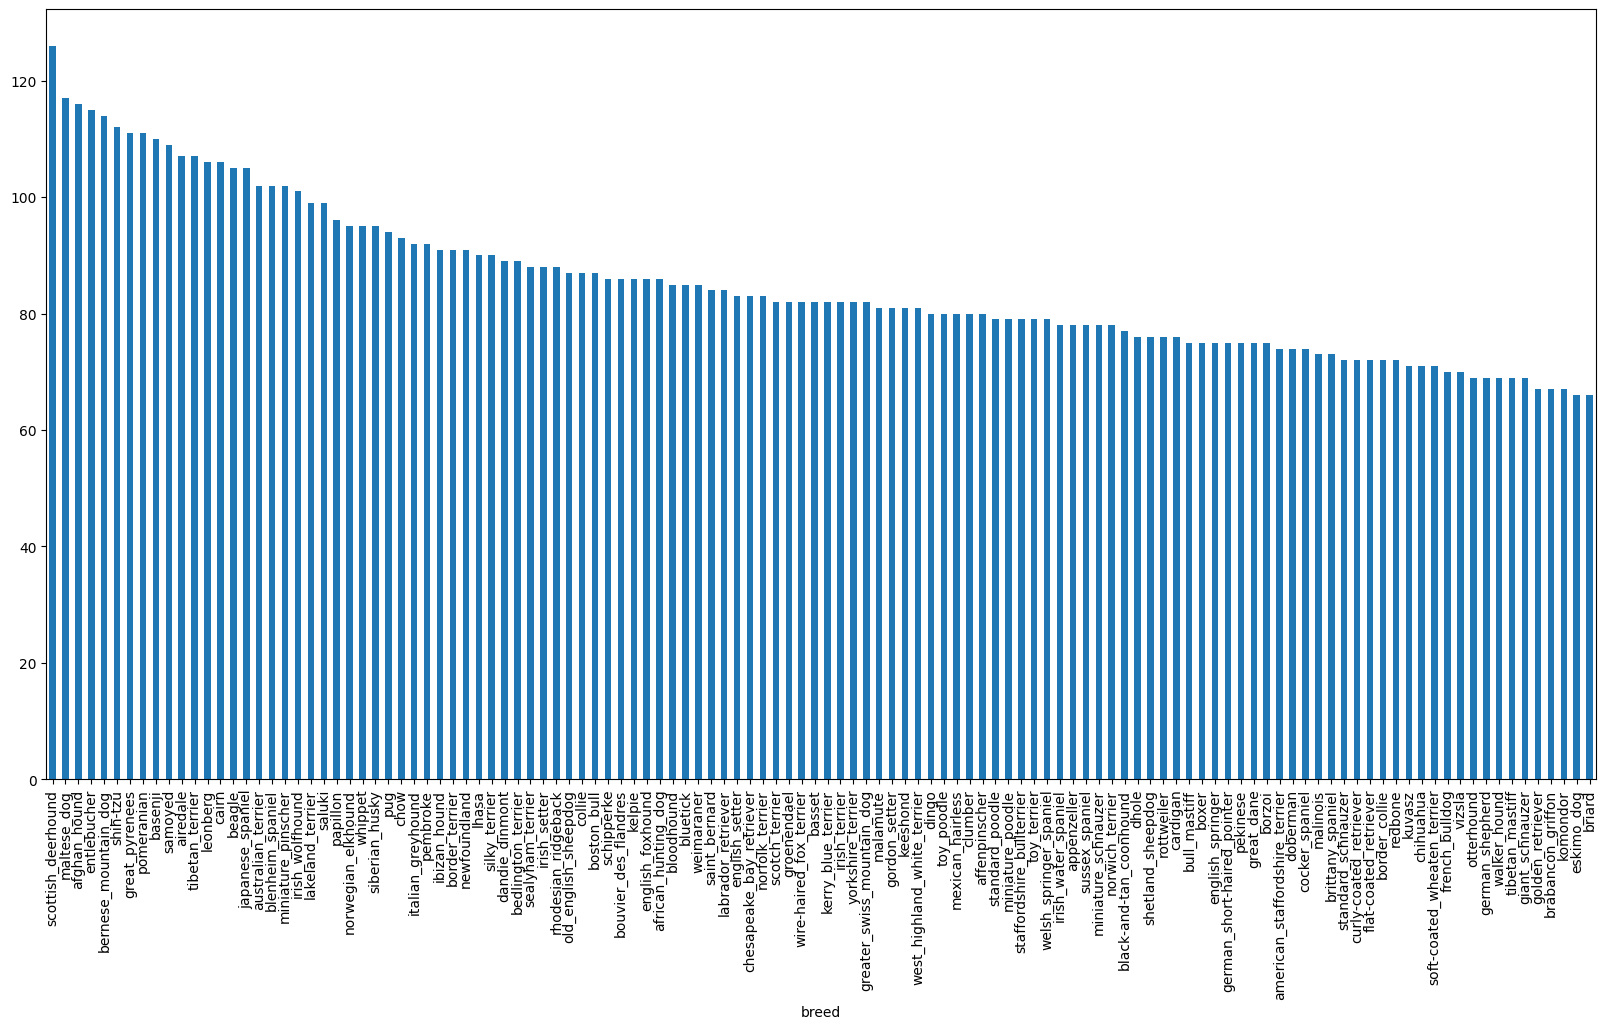

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

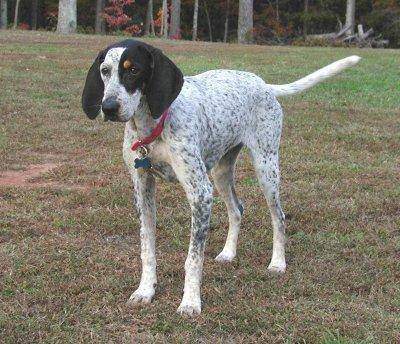

In [7]:
# Let's view an image ## to view the command info within the bracket use strg+shift+space
from IPython.display import Image
Image("drive/MyDrive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels

Let us get a list of all our image file pathnames.


In [8]:
# Create pathnames from image ID's
path_name="drive/MyDrive/Colab Notebooks/Dog Vision/train/"
ext_name= ".jpg"
filenames = [path_name+fname+ext_name for fname in labels_csv["id"] ]
filenames[0:5]

['drive/MyDrive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [9]:
# Check whether the number of filenames matches number of actual image files
len(filenames)

10222

In [10]:
# alternative approach
import os
if len(os.listdir("drive/MyDrive/Colab Notebooks/Dog Vision/train/")) == len(filenames):
  print("File names match actual amount of files !!! Proceed")
else:
  print("Issue with number of files in file name")

File names match actual amount of files !!! Proceed


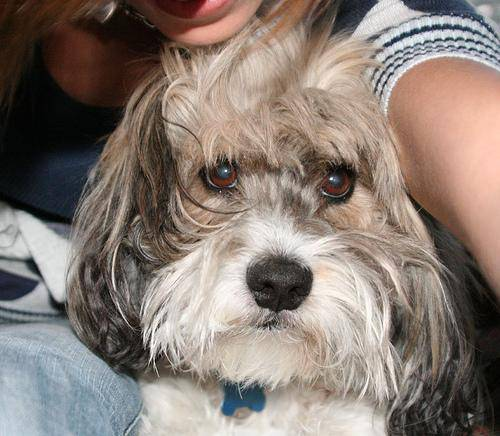

In [11]:
# One more check
Image(filenames[900])

In [12]:
labels_csv["breed"][900]

'lhasa'

Since we have now got our training image file paths in a list, let us prepare our labels.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) # does the same as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# Check if the number of labels match the number of filenames
if len(labels) == len(filenames):
  print("Success number of labels match number of filenames")
else:
  print("Error there is a mismatch with number of labels and filenames")

Success number of labels match number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:5]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # this is the index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there should be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
print(labels[2])
print(boolean_labels[2].argmax())
print(boolean_labels[2].astype(int))

pekinese
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
filenames[:10]

['drive/MyDrive/Colab Notebooks/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Colab Notebooks/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own Validation set
Since the dataset from Kaggle does not come with a validation set we are going to create our own.

In [25]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [26]:
len(filenames)

10222

We are going to start off with approx 1000 images and increase when needed for efficiency purposes.

In [27]:
# Set numebr of images to use for experimentation
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step:1000}

In [28]:
# Let us split our data int a train and validation sets
from sklearn.model_selection import train_test_split

# Split data into training and validation of total size of NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val),  len(y_val)

(800, 800, 200, 200)

In [29]:
# Let us look at the trainig validation data
X_train[:5], y_train[:2]

(['drive/MyDrive/Colab Notebooks/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Colab Notebooks/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,

## Preprocessing images (Turning images into Tensors)

To preprocess our images into Tensors we are going to write
a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read a file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our `image`(convert our colour channel values from 0-255 to 0-1)
5. Resize the `image` to dimensions of shape (224,224)
6. Return the modified `image`

Before we do, let us see what importing an image looks like.


In [30]:
# Converting image into a Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [31]:
image.max(), image.min()

(255, 0)

In [32]:
## Create a Tensor from image
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we have seen above what an image looks like as a Tensor,
let us create a function to preprocess all the images in the X_train data set.

1. Take an image filepath as input
2. Use Tensorflow to read a file and save it to a variable, `image`
3. Turn our `image` (jpg) into Tensors
4. Normalize our `image`(convert our colour channel values from 0-255 to 0-1)
5. Resize the `image` to dimensions of shape (224,224)
6. Return the modified `image`

In [33]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image filepath and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  #Turn the jpg image into a numerical Tensor with 3 colour channels (Red,Green,Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



## Turning our data into batches

Why turn our data into batches?

Let us say you are trying to process 10,000+ images in one run
they all might not fit into the computer memory.
This is the reason why we use 32 (batch size) at a time (you can manually adjust
the batch size if needed)

In order to use TensorFlow effectively, we need our data in the form of Tensor
Tuples which look like this:
`(image,label)`.

In [34]:
# Create a simple function to return a tuple (image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image,label)
  """
  image= process_image(image_path)
  return image, label

In [35]:
get_image_label(X_train[1],tf.constant(y[1]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.18755254, 0.21500352, 0.24637607],
         [0.1764706 , 0.20050772, 0.23461136],
         [0.17305672, 0.18089986, 0.2279587 ],
         ...,
         [0.44908977, 0.5404238 , 0.43163532],
         [0.42711818, 0.5011202 , 0.43802518],
         [0.40852585, 0.4754201 , 0.43529415]],
 
        [[0.16093954, 0.18839052, 0.21976307],
         [0.15317924, 0.17825271, 0.21183819],
         [0.15481427, 0.16688253, 0.21182881],
         ...,
         [0.4626288 , 0.55693907, 0.4591917 ],
         [0.3884407 , 0.46787694, 0.4117706 ],
         [0.36634105, 0.44199118, 0.40501413]],
 
        [[0.13412693, 0.16599749, 0.19985214],
         [0.13486801, 0.16027068, 0.19756654],
         [0.14402403, 0.15743439, 0.20170961],
         ...,
         [0.25783715, 0.36013058, 0.282312  ],
         [0.2909582 , 0.38303342, 0.3436311 ],
         [0.30534175, 0.39550284, 0.37139183]],
 
        ...,
 
        [[0.5555578 , 0.67555076

In [36]:
# Demo of above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn to turn our data into tuples of Tensors in the form of `(image,label)`, let us make a function to turn all our data (`X` & `y`)
into batches!

In [37]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of  image(X) and image(y) pairs.
  Shuffles the data if it's training data but does not shuffle if it is validation data.
  Also accepts test data as input (no labels).
  """
  # if the data is a test dataset, we want to allow the function to run without labels
  if test_data:
    print("Creating test data batches.....")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is a valid dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches.....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches.....")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) # filepaths # labels
    #print(data)
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (iamge,label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [38]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches.....
Creating validation data batches.....


In [39]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand/comprehend.
Let us visualize them.

In [40]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  	Display a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [41]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [42]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.60387516, 0.52936536, 0.50583595],
          [0.6514714 , 0.57696164, 0.5534322 ],
          [0.6765378 , 0.602028  , 0.5776058 ],
          ...,
          [0.7133927 , 0.6624123 , 0.6289841 ],
          [0.7157153 , 0.6647349 , 0.6300771 ],
          [0.7325437 , 0.6815633 , 0.6468624 ]],
 
         [[0.66579294, 0.5966166 , 0.5766945 ],
          [0.64181143, 0.57514477, 0.5476938 ],
          [0.6381348 , 0.5714681 , 0.54401714],
          ...,
          [0.7327115 , 0.679162  , 0.6630687 ],
          [0.7275019 , 0.6756454 , 0.65386754],
          [0.72593933, 0.67414224, 0.65216464]],
 
         [[0.72948635, 0.67097795, 0.65984344],
          [0.6873081 , 0.6287997 , 0.61766523],
          [0.6691352 , 0.6106268 , 0.59164923],
          ...,
          [0.74723405, 0.6923321 , 0.68872565],
          [0.73934275, 0.6844408 , 0.68083435],
          [0.7246948 , 0.66979283, 0.6661864 ]],
 
         ...,
 
         [[0.3950851 , 0.3950851 , 0.3950851 ],
          [0.41123

In [43]:
unique_breeds[y[0].argmax()]

'boston_bull'

In [45]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [44]:
len(train_images),len(train_labels)

(32, 32)

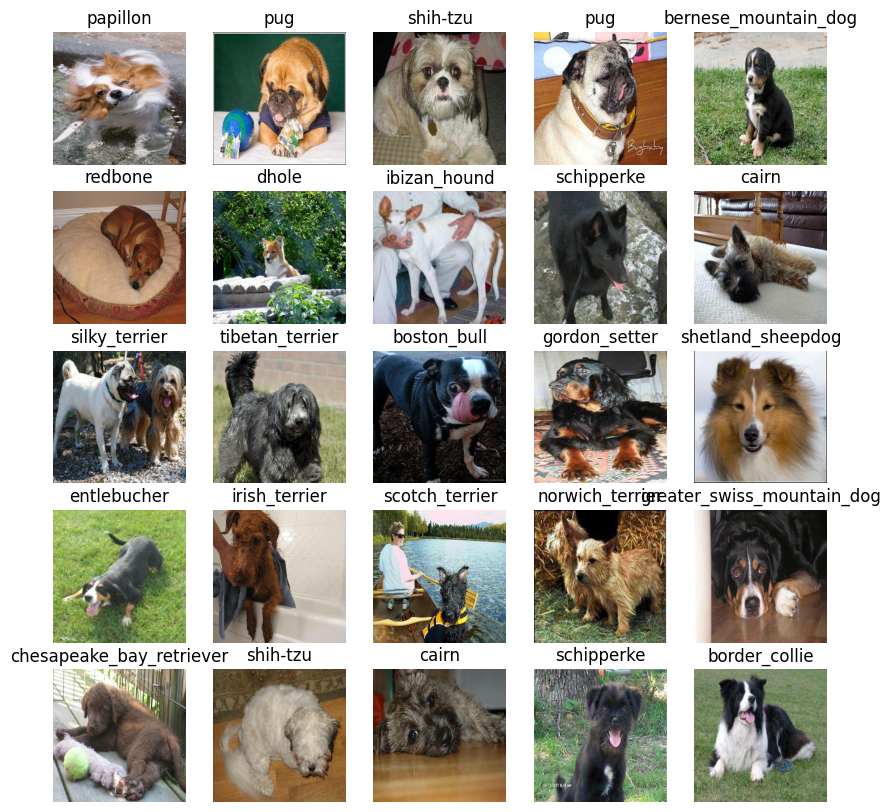

In [48]:
# Now let us vizialize the data in a training batch
show_25_images(train_images, train_labels)

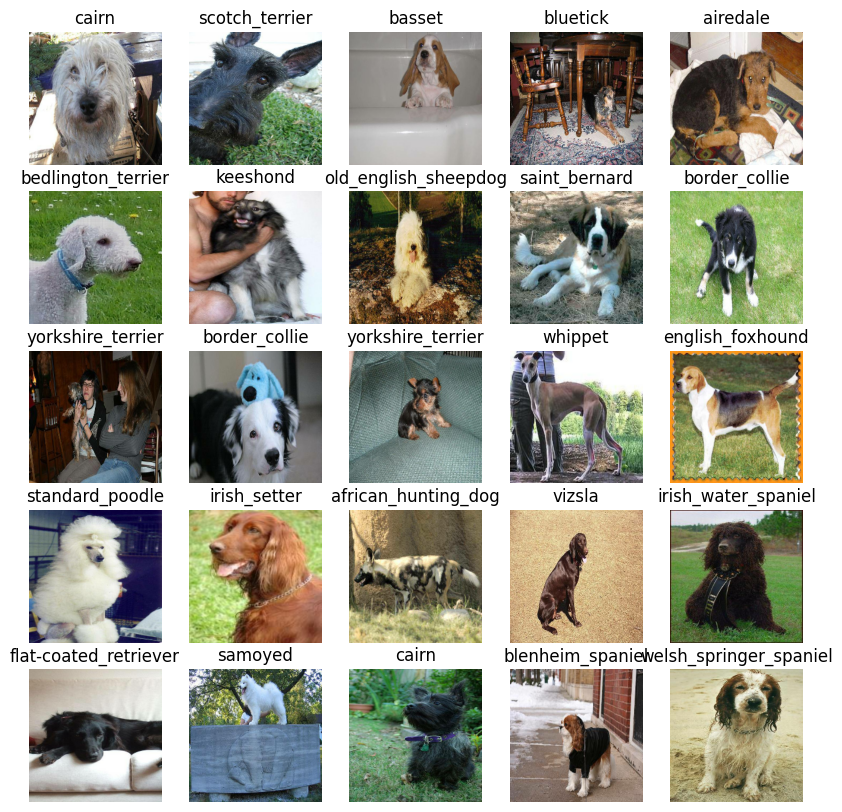

In [49]:
# Now ltes visualize our validation set
val_iamges, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_iamges, val_labels)